In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/BMW.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_1 Serisi,Seri_2 Serisi,Seri_3 Serisi,...,Model_Z4 3.0,Model_Z4 3.0i sDrive,Model_Z4 3.5i sDrive,Model_Z4 M,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,1875000,2021,170,1597,25000,1.0,2.0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
1,1650000,2018,190,1995,63000,0.0,0.0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
2,875000,2011,177,1995,234000,1.0,0.0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
3,1340000,2015,176,1401,99750,4.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,495000,2010,177,1995,243000,8.0,0.0,0,0,1,...,0,0,0,0,0,1,0,0,1,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_14688\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,283991.581444,5.566312e+10,235930.334803,108926.214672


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': [10000],
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:06:22,225] A new study created in memory with name: no-name-2019fecb-14e4-403b-aadf-0af75c016185
[I 2023-10-08 14:06:22,786] Trial 3 finished with value: 1144107.4231690087 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.020788763727106318, 'max_depth': 8, 'min_child_weight': 300}. Best is trial 3 with value: 1144107.4231690087.
[I 2023-10-08 14:06:22,817] Trial 0 finished with value: 708521.2356210541 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.1011166574830705, 'max_depth': 8, 'min_child_weight': 276}. Best is trial 0 with value: 708521.2356210541.
[I 2023-10-08 14:06:22,920] Trial 6 finished with value: 673218.6596125531 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.10439170773466981, 'max_depth': 15, 'min_child_weight': 204}. Best is trial 6 with value: 673218.6596125531.
[I 2023-10-08 14:06:22,925] Trial 7 finished with value: 1221409.314212436 and parameters: {'cols

[I 2023-10-08 14:06:25,627] Trial 30 finished with value: 471569.2255365164 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.19033085652463982, 'max_depth': 14, 'min_child_weight': 100}. Best is trial 19 with value: 253605.994620189.
[I 2023-10-08 14:06:25,785] Trial 32 finished with value: 489570.149857196 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.17519403486328827, 'max_depth': 14, 'min_child_weight': 90}. Best is trial 19 with value: 253605.994620189.
[I 2023-10-08 14:06:25,814] Trial 31 finished with value: 462850.3665381007 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.2061133802575513, 'max_depth': 14, 'min_child_weight': 95}. Best is trial 19 with value: 253605.994620189.
[I 2023-10-08 14:06:25,893] Trial 33 finished with value: 466552.503940106 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.20706200817155865, 'max_depth': 14, 'min_child_weight': 99

[I 2023-10-08 14:06:29,320] Trial 61 finished with value: 491890.0955043224 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.26893324596892204, 'max_depth': 9, 'min_child_weight': 201}. Best is trial 19 with value: 253605.994620189.
[I 2023-10-08 14:06:29,376] Trial 60 finished with value: 435528.3931792272 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.26795987651074105, 'max_depth': 9, 'min_child_weight': 121}. Best is trial 19 with value: 253605.994620189.
[I 2023-10-08 14:06:29,480] Trial 62 finished with value: 433491.38465953857 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.28761411526436254, 'max_depth': 9, 'min_child_weight': 228}. Best is trial 19 with value: 253605.994620189.
[I 2023-10-08 14:06:29,736] Trial 65 finished with value: 358843.19047978206 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.34289938543998677, 'max_depth': 9, 'min_child_weight':

[I 2023-10-08 14:06:33,728] Trial 91 finished with value: 333255.988791231 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.37611881065855, 'max_depth': 15, 'min_child_weight': 31}. Best is trial 75 with value: 227729.4817829433.
[I 2023-10-08 14:06:33,816] Trial 93 finished with value: 327905.18302302825 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.3650204179835045, 'max_depth': 14, 'min_child_weight': 35}. Best is trial 75 with value: 227729.4817829433.
[I 2023-10-08 14:06:33,824] Trial 92 finished with value: 341484.7477148966 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.3827196287779476, 'max_depth': 14, 'min_child_weight': 34}. Best is trial 75 with value: 227729.4817829433.
[I 2023-10-08 14:06:33,872] Trial 90 finished with value: 288065.4008129145 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.36686302830410283, 'max_depth': 15, 'min_child_weight': 1}

[I 2023-10-08 14:06:38,446] Trial 120 finished with value: 226222.22452740063 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.3277335029866586, 'max_depth': 12, 'min_child_weight': 5}. Best is trial 120 with value: 226222.22452740063.
[I 2023-10-08 14:06:38,487] Trial 122 finished with value: 224194.03216475554 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.3227744282361922, 'max_depth': 12, 'min_child_weight': 5}. Best is trial 122 with value: 224194.03216475554.
[I 2023-10-08 14:06:38,501] Trial 119 finished with value: 221585.22340243025 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.3201185455419721, 'max_depth': 12, 'min_child_weight': 4}. Best is trial 119 with value: 221585.22340243025.
[I 2023-10-08 14:06:38,578] Trial 123 finished with value: 212139.17262344307 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.3254389321131503, 'max_depth': 12, 'min_child

[I 2023-10-08 14:06:43,689] Trial 151 finished with value: 896548.6930326079 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.041583361668583035, 'max_depth': 11, 'min_child_weight': 8}. Best is trial 137 with value: 211667.5833130804.
[I 2023-10-08 14:06:43,705] Trial 149 finished with value: 300965.1032696394 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.19016311947346506, 'max_depth': 11, 'min_child_weight': 8}. Best is trial 137 with value: 211667.5833130804.
[I 2023-10-08 14:06:43,780] Trial 152 finished with value: 231518.71480395168 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.3464429725587896, 'max_depth': 11, 'min_child_weight': 8}. Best is trial 137 with value: 211667.5833130804.
[I 2023-10-08 14:06:43,786] Trial 153 finished with value: 1054816.0310127933 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.02417991511145046, 'max_depth': 11, 'min_child_

[I 2023-10-08 14:06:47,814] Trial 180 finished with value: 251930.0369423785 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.42425786672960214, 'max_depth': 11, 'min_child_weight': 5}. Best is trial 137 with value: 211667.5833130804.
[I 2023-10-08 14:06:48,383] Trial 181 finished with value: 223415.7758223289 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.39686215259322505, 'max_depth': 11, 'min_child_weight': 5}. Best is trial 137 with value: 211667.5833130804.
[I 2023-10-08 14:06:49,009] Trial 183 finished with value: 227254.33339515346 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.41343620204286036, 'max_depth': 13, 'min_child_weight': 6}. Best is trial 137 with value: 211667.5833130804.
[I 2023-10-08 14:06:49,119] Trial 184 finished with value: 235304.81388687805 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.4162002956612915, 'max_depth': 13, 'min_child_w

[I 2023-10-08 14:06:53,423] Trial 210 finished with value: 246141.42350534353 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.3692801361185753, 'max_depth': 13, 'min_child_weight': 14}. Best is trial 137 with value: 211667.5833130804.
[I 2023-10-08 14:06:53,730] Trial 212 finished with value: 238307.87714162888 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.37194623755624423, 'max_depth': 13, 'min_child_weight': 14}. Best is trial 137 with value: 211667.5833130804.
[I 2023-10-08 14:06:53,730] Trial 211 finished with value: 237559.03834947443 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.37679719332750966, 'max_depth': 13, 'min_child_weight': 14}. Best is trial 137 with value: 211667.5833130804.
[I 2023-10-08 14:06:53,801] Trial 214 finished with value: 246497.81144541843 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.368647840103228, 'max_depth': 12, 'min_chil

[I 2023-10-08 14:06:58,386] Trial 243 finished with value: 224324.55773470105 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.3408341936315473, 'max_depth': 11, 'min_child_weight': 9}. Best is trial 137 with value: 211667.5833130804.
[I 2023-10-08 14:06:58,562] Trial 240 finished with value: 225385.37492868275 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.3423363908442318, 'max_depth': 11, 'min_child_weight': 9}. Best is trial 137 with value: 211667.5833130804.
[I 2023-10-08 14:06:58,746] Trial 241 finished with value: 228337.61089192374 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.3395117857986301, 'max_depth': 11, 'min_child_weight': 8}. Best is trial 137 with value: 211667.5833130804.
[I 2023-10-08 14:06:58,818] Trial 242 finished with value: 217609.70718831278 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.3445657463628952, 'max_depth': 11, 'min_child_we

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 211667.5833
Best params:
	colsample_bytree: 0.8
	subsample: 0.8
	learning_rate: 0.43986154837740843
	max_depth: 12
	min_child_weight: 4


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 312900.5446436925, 'MSE': 42106225738.07115, 'RMSE': 205198.01592138057, 'MAE': 120108.8390877016}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9344819536717162

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.9172293893641092

In [16]:
marka_model = joblib.dump(final_model, "BMW.pkl")

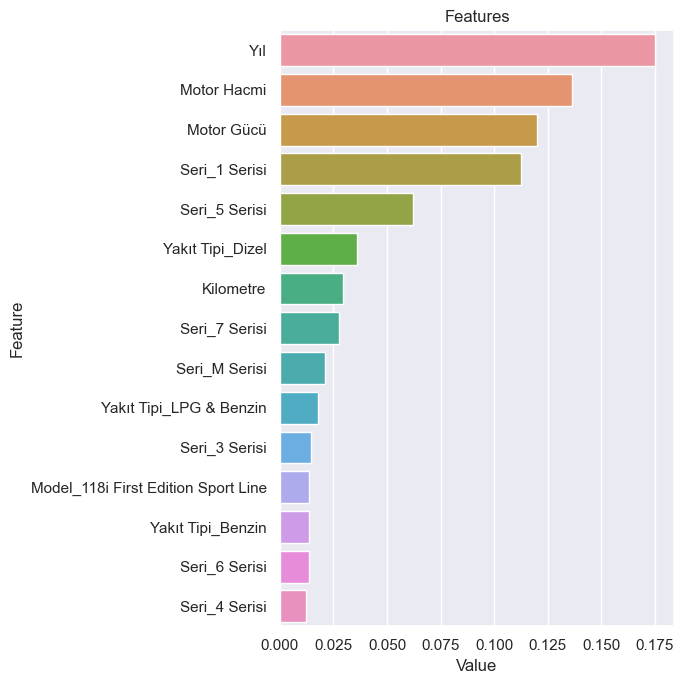

In [18]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)